In [10]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import MultiHeadAttention
from keras.preprocessing.image import ImageDataGenerator

In [11]:
# Load the model from the H5 file
loaded_model = load_model('densenet121_model.h5')

# Print the shape of the feature extraction layer for debugging
print("Feature Shape:", loaded_model.layers[-3].output_shape[1:])

Feature Shape: (64,)


In [12]:
train_path = './train'
test_path = './test'
val_path = './val'

In [13]:
size_images = 150
batch_size = 32

In [14]:
train_datagen = ImageDataGenerator(
    rescale=1.0/255,                # Rescale pixel values to [0, 1]
)
train_generator = train_datagen.flow_from_directory(
    train_path,                     # Path to the training data
    target_size=(size_images, size_images),  # Resize images to this size
    batch_size = batch_size,        # Number of images in each batch
    class_mode ='categorical'       # Mode for class labels (categorical for one-hot encoding)
)

test_datagen = ImageDataGenerator(rescale=1.0/255)
test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=(size_images, size_images),
    batch_size = batch_size,
    class_mode='categorical')

val_datagen = ImageDataGenerator(rescale=1.0/255)

val_generator = val_datagen.flow_from_directory(
    val_path,
    target_size=(size_images, size_images),
    batch_size=batch_size,
    class_mode='categorical'
)

Found 31571 images belonging to 4 classes.
Found 6769 images belonging to 4 classes.
Found 6765 images belonging to 4 classes.


In [15]:
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
# Define a learning rate schedule function
def lr_schedule(epoch):
    initial_lr = 0.001
    drop = 0.5
    epochs_drop = 5
    lr = initial_lr * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    return lr

early_stopping = EarlyStopping(
    min_delta=0.001,
    patience=5,
    restore_best_weights=True,
)

# Use the LearningRateScheduler callback
lr_callback = LearningRateScheduler(lr_schedule)

In [16]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.layers import MultiHeadAttention
from tensorflow.keras.optimizers import Adam
# Assuming you have a pre-trained feature extractor model (e.g., a CNN)
pretrained_feature_extractor = loaded_model.layers[-3]

# Get the output shape of the feature extraction layer
feature_shape = pretrained_feature_extractor.output_shape[1:]

base_model = models.Model(inputs=loaded_model.input, outputs=loaded_model.layers[-3].output)
# Print the shape for debugging
print("Feature Shape:", feature_shape)

Feature Shape: (64,)


In [17]:
# Define your transformer model
def transformer_model(input_shape, num_transformer_layers, output_dim):
    inputs = tf.keras.Input(shape=input_shape)
    
    # Add a "sequence_length" dimension to the input
    sequence = layers.Reshape((1, input_shape[0]))(inputs)
    
    # Transformer layers using MultiHeadAttention
    sequence = MultiHeadAttention(num_heads=5, key_dim=64)(sequence, sequence)
    sequence = layers.LayerNormalization(epsilon=1e-6)(sequence)
    sequence = layers.Dropout(0.1)(sequence)
    
    # Reshape the sequence to maintain 3D structure
    sequence = layers.Reshape((-1, feature_shape[0]))(sequence)
    
    # Output layer for your specific task
    outputs = layers.Dense(output_dim, activation='softmax')(sequence)
    
    model = models.Model(inputs=inputs, outputs=outputs)
    return model

# Define your task-specific output dimension (e.g., number of classes)
output_dim = 4
num_tlayers = 2

# Create the transformer model
transformer = transformer_model(input_shape=feature_shape, num_transformer_layers=num_tlayers, output_dim=output_dim)

# Print the summary of the model for debugging
transformer.summary()


Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 64)]         0                                            
__________________________________________________________________________________________________
reshape_2 (Reshape)             (None, 1, 64)        0           input_2[0][0]                    
__________________________________________________________________________________________________
multi_head_attention_1 (MultiHe (None, 1, 64)        82944       reshape_2[0][0]                  
                                                                 reshape_2[0][0]                  
__________________________________________________________________________________________________
layer_normalization_1 (LayerNor (None, 1, 64)        128         multi_head_attention_1[0][0

In [18]:
# Combine the pre-trained feature extractor with the transformer
combined_model = models.Sequential([
    base_model,
    transformer,
    layers.Flatten()  # Add Flatten layer to reshape the output
])

# Compile the model (adjust loss and metrics based on your task)
combined_model.compile(optimizer=Adam(learning_rate=0.000005), loss='categorical_crossentropy', metrics=['accuracy'])

# Print the summary of the combined model
combined_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_2 (Functional)         (None, 64)                7341056   
_________________________________________________________________
model_3 (Functional)         (None, 1, 4)              83332     
_________________________________________________________________
flatten_1 (Flatten)          (None, 4)                 0         
Total params: 7,424,388
Trainable params: 386,884
Non-trainable params: 7,037,504
_________________________________________________________________


In [19]:
# Train the model
import math
history = combined_model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=20,
    validation_data=val_generator,
    validation_steps=val_generator.samples // batch_size,
    callbacks=[early_stopping, lr_callback]
)

Epoch 1/20
986/986 [==============================] - 191s 178ms/step - loss: 0.1479 - accuracy: 0.9553 - val_loss: 0.1092 - val_accuracy: 0.9679
Epoch 2/20
986/986 [==============================] - 176s 179ms/step - loss: 0.1230 - accuracy: 0.9597 - val_loss: 0.1128 - val_accuracy: 0.9649
Epoch 3/20
986/986 [==============================] - 174s 176ms/step - loss: 0.1200 - accuracy: 0.9601 - val_loss: 0.1058 - val_accuracy: 0.9670
Epoch 4/20
986/986 [==============================] - 177s 180ms/step - loss: 0.1115 - accuracy: 0.9624 - val_loss: 0.1049 - val_accuracy: 0.9680
Epoch 5/20
986/986 [==============================] - 180s 182ms/step - loss: 0.0826 - accuracy: 0.9720 - val_loss: 0.0932 - val_accuracy: 0.9696
Epoch 6/20
986/986 [==============================] - 179s 182ms/step - loss: 0.0776 - accuracy: 0.9734 - val_loss: 0.0964 - val_accuracy: 0.9701
Epoch 7/20
986/986 [==============================] - 176s 178ms/step - loss: 0.0723 - accuracy: 0.9754 - val_loss: 0.0898 -

In [20]:
test_results = combined_model.evaluate(test_generator, steps=test_generator.samples // batch_size)
print("Test Loss:", test_results[0])
print("Test Accuracy:", test_results[1])

211/211 [==============================] - 32s 152ms/step - loss: 0.0809 - accuracy: 0.9741
Test Loss: 0.08092033118009567
Test Accuracy: 0.9740817546844482


In [21]:
combined_model.save('densenet121_vit_model.h5')

ValueError: Unable to synchronously create dataset (name already exists)

In [22]:
import numpy as np

# Initialize lists to accumulate predictions and true labels
all_predictions = []
all_true_labels = []

# Loop through all batches in the test generator
for _ in range(len(test_generator)):
    images, labels = test_generator.next()

    # Predictions on the current batch
    batch_predictions = combined_model.predict(images)
    all_predictions.extend(batch_predictions)
    
    # True labels for the current batch
    batch_true_labels = np.argmax(labels, axis=1)
    all_true_labels.extend(batch_true_labels)

# Convert lists to numpy arrays
all_predictions = np.array(all_predictions)
all_true_labels = np.array(all_true_labels)

# Extract predicted labels from all predictions
predicted_labels = np.argmax(all_predictions, axis=1)

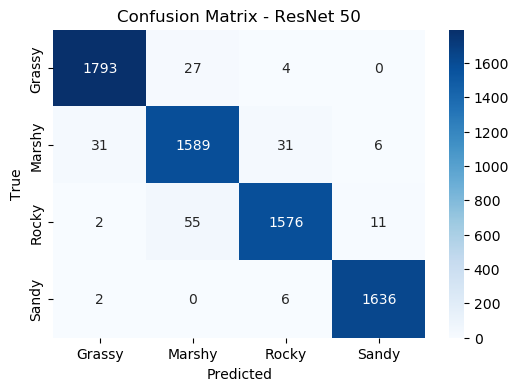

In [26]:
# Confusion Matrix
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
conf_mat = confusion_matrix(all_true_labels, predicted_labels)

# Plot the confusion matrix
class_names = ['Grassy', 'Marshy', 'Rocky', 'Sandy']  # Update with your actual class names
plt.figure(figsize=(6, 4))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix - ResNet 50')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [24]:
# Calculate percentage of correct predictions for each class
correctly_classified = np.diag(conf_mat)
total_true_per_class = np.sum(conf_mat, axis=1)
percentage_correct_per_class = (correctly_classified / total_true_per_class) * 100

# Display the percentage of correct predictions for each class
for i, class_name in enumerate(class_names):
    print(f'Percentage of correct predictions for {class_name}: {percentage_correct_per_class[i]:.2f}%')


Percentage of correct predictions for Grassy: 98.30%
Percentage of correct predictions for Marshy: 95.90%
Percentage of correct predictions for Rocky: 95.86%
Percentage of correct predictions for Sandy: 99.51%


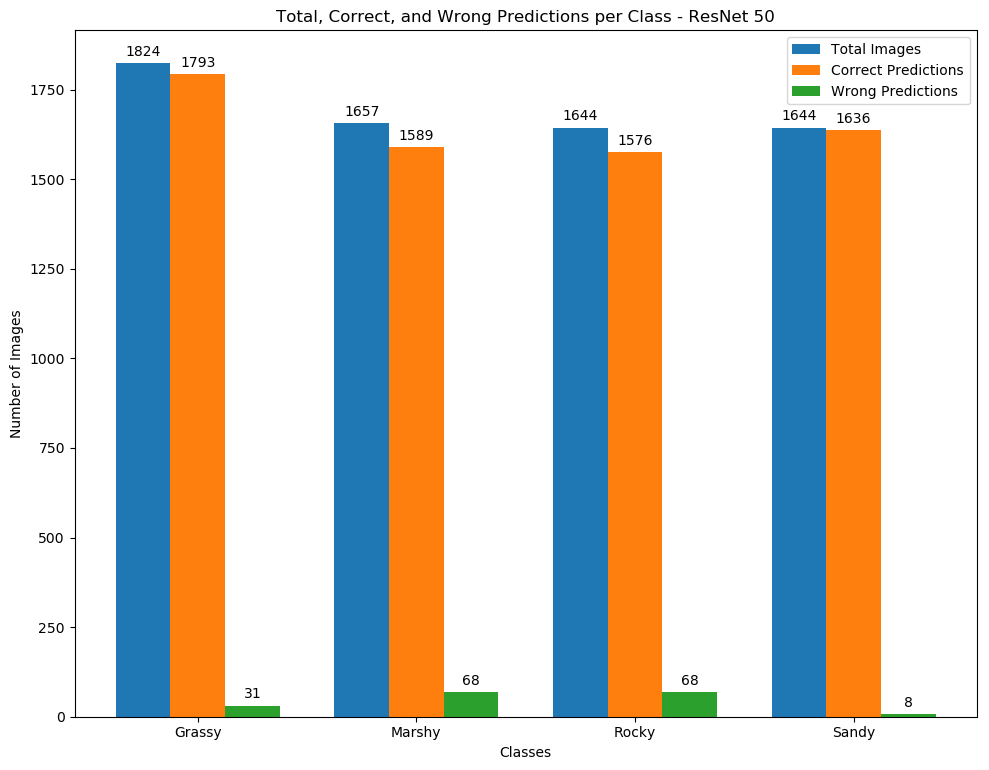

In [25]:
class_names = ['Grassy', 'Marshy', 'Rocky', 'Sandy']  # Update with your actual class names

# Print the number of images classified correctly and wrongly in each class
correctly_classified = np.diag(conf_mat)
wrongly_classified = np.sum(conf_mat, axis=1) - correctly_classified

# Total number of images in each class
total_images_per_class = np.sum(conf_mat, axis=1)

x = np.arange(len(class_names))
width = 0.25

fig, ax = plt.subplots(figsize=(10, 6))

rects1 = ax.bar(x - width, total_images_per_class, width, label='Total Images')
rects2 = ax.bar(x, correctly_classified, width, label='Correct Predictions')
rects3 = ax.bar(x + width, wrongly_classified, width, label='Wrong Predictions')

ax.set_xlabel('Classes')
ax.set_ylabel('Number of Images')
ax.set_title('Total, Correct, and Wrong Predictions per Class - ResNet 50')
ax.set_xticks(x)
ax.set_xticklabels(class_names)
ax.legend()

# Display the number of images on top of each bar with proper spacing
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)
autolabel(rects3)

# Adjust layout to prevent overlapping
plt.tight_layout(rect=[0, 0, 1, 1.3])  # Increase the value in the last argument if necessary

plt.show()

In [1]:
import numpy as np

def calculate_metrics_and_report(confusion_matrix, class_names, total_per_class):
  """
  This function calculates and displays various metrics and a classification report.

  Args:
      confusion_matrix: A numpy array representing the confusion matrix.
      class_names: A list containing the names of the classes.
      total_per_class (optional): A list containing the total number of images per class 
                                    (if available). Used to estimate FN_X.

  Returns:
      None (prints the metrics and report to the console).
  """

  # Calculate class-wise elements
  TP = np.diag(confusion_matrix)  # True positives (diagonal elements)
  FP = confusion_matrix.sum(axis=0) - TP  # False positives (row sums minus diagonals)
  FN = confusion_matrix.sum(axis=1) - TP  # False negatives (column sums minus diagonals)
  TN = confusion_matrix.sum() - (TP + FP + FN)  # True negatives (all elements minus TP, FP, FN)

  # Calculate totals
  total_support = confusion_matrix.sum(axis=0)  # Total predicted instances per class
  total_ground_truth = confusion_matrix.sum(axis=1)  # Total true instances per class

  # Calculate class-wise accuracy
  class_wise_accuracy = TP / (TP + FP + FN)

  # Macro-average (requires FN values)
  if total_per_class is not None:
      # Estimate FN_X if total images per class are provided
      FN_X = total_per_class - TP
      macro_precision = np.mean(TP / (TP + FP))
      macro_recall = np.mean(TP / FN_X)
      macro_f1 = np.mean(2 * (macro_precision * macro_recall) / (macro_precision + macro_recall))
  else:
      macro_precision = np.nan
      macro_recall = np.nan
      macro_f1 = np.nan

  # Micro-average
  micro_precision = TP.sum() / (TP.sum() + FP.sum())
  micro_recall = TP.sum() / (TP.sum() + FN.sum()) if total_per_class is not None else np.nan  # Avoid division by zero
  micro_f1 = 2 * (micro_precision * micro_recall) / (micro_precision + micro_recall)

  # Build the classification report string
  report = "             Precision    Recall  F1-Score   Support\n"
  for i, class_name in enumerate(class_names):
      precision = TP[i] / (TP[i] + FP[i]) if (TP[i] + FP[i]) > 0 else 0.0
      recall = TP[i] / (TP[i] + FN[i]) if (TP[i] + FN[i]) > 0 else 0.0
      f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0.0
      support = total_predicted_instances = total_support[i]
      report += f"{class_name:14}  {precision:.4f}  {recall:.4f}  {f1:.4f}         {support}\n"

  # Add support for all classes
  report += f"accuracy         {TP.sum() / confusion_matrix.sum():.4f}        {total_ground_truth.sum()}\n"

  # Print results
  print("Class-wise Accuracy:")
  for i, class_name in enumerate(class_names):
      print(f"\t{class_name}: {class_wise_accuracy[i]:.4f}")
  print("\nClassification Report:")
  print(report)

  print("\nMacro Average (requires FN values):")
  print(f"\tPrecision: {macro_precision:.4f}")
  print(f"\tRecall: {macro_recall:.4f}")  # Print NaN if FN_X not available
  print(f"\tF1-Score: {macro_f1:.4f}")  # Print NaN if FN_X not


# Example usage
confusion_matrix = np.array([[1793, 27, 4, 0],
                             [31, 1589, 31, 6],
                             [2, 55, 1576, 11],
                             [2, 0, 6, 1636]])

class_names = ["Grassy", "Marshy", "Rocky", "Sandy"]
# Example: Assuming you have total images per class (replace with your actual values)
total_per_class = [1824, 1657, 1644, 1644]

report = calculate_metrics_and_report(confusion_matrix, class_names,total_per_class)
print(report)

Class-wise Accuracy:
	Grassy: 0.9645
	Marshy: 0.9137
	Rocky: 0.9353
	Sandy: 0.9849

Classification Report:
             Precision    Recall  F1-Score   Support
Grassy          0.9809  0.9830  0.9819         1828
Marshy          0.9509  0.9590  0.9549         1671
Rocky           0.9746  0.9586  0.9666         1617
Sandy           0.9897  0.9951  0.9924         1653
accuracy         0.9741        6769


Macro Average (requires FN values):
	Precision: 0.9740
	Recall: 77.2207
	F1-Score: 1.9238
None
